In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 500
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib.patches import FancyArrowPatch
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits
import os
from scipy.ndimage import map_coordinates
from scipy.stats import binned_statistic
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

from matplotlib.lines import Line2D
os.chdir("/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Lens Modelling")

In [2]:
# Model Opening
model_path = 'Test/SIE+SHEAR'
model_ver = 'SIE_POS_SHEAR'
lens_name = f'"{model_path}"'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result

['------------------------------------------\n',
 'optimize ndim=0\n',
 'run 1: 0 lens models calculated\n',
 'chi^2 = 0.000000e+00  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.078000e+01  2.078000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.078000e+01  2.078000e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 \n',
 'point  1.0000  2.078000e+01  2.078000e+01 \n',
 '------------------------------------------\n']

In [3]:
# Find the last line with 'optimize' in it
last_optimize_index = None
for idx in range(len(opt_result) - 1, -1, -1):
    if 'optimize' in opt_result[idx]:
        last_optimize_index = idx
        last_optimize_line = opt_result[idx]
        break
if last_optimize_index is None:
    raise ValueError("No line with 'optimize' found in the file.")

print(f"Last 'optimize' line found at index: {last_optimize_index}")

# Extract everything after the last 'optimize' line
opt_result = opt_result[last_optimize_index + 1:]

opt_result


Last 'optimize' line found at index: 1


['run 1: 0 lens models calculated\n',
 'chi^2 = 0.000000e+00  [N_data(extend): 0]\n',
 ' extend     : 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' point no 1 : 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00\n',
 ' lens prior : 0.000000e+00\n',
 ' map prior  : 0.000000e+00\n',
 '\n',
 'omega = 0.3000  lambda = 0.7000  weos = -1.0000  hubble = 0.7000\n',
 '\n',
 'lens   sie     0.2613  1.300000e+02  2.078000e+01  2.078000e+01  1.070000e-01  2.338000e+01  0.000000e+00  0.000000e+00 \n',
 'lens   pert    0.2613  1.000000e+00  2.078000e+01  2.078000e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 \n',
 'point  1.0000  2.078000e+01  2.078000e+01 \n',
 '------------------------------------------\n']

In [4]:
# Count the number of lines that start with 'lens'
lens_count = sum(1 for line in opt_result if line.startswith('lens'))
print(f"Number of 'lens' lines: {lens_count}")

# Initialize a dictionary to hold the lens parameters
lens_params_dict = {}

# Extract the lens parameters
lens_params = []
for line in opt_result:
    if line.startswith('lens'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)
        # Extract the lens name and parameters
        lens_name = parts[1]
        params = [float(x) for x in parts[2:]]

        # Store the parameters in the dictionary
        lens_params_dict[lens_name] = params
        lens_params.append((lens_name, params))

# Remove the first lens parameter
if lens_params:
    for i in range(len(lens_params)):
        lens_name, params = lens_params[i]
        lens_params_dict[lens_name] = params[1:]


# Number of len profiles
num_lens_profiles = len(lens_params_dict)
print(f"Number of lens profiles: {num_lens_profiles}")
    
lens_params_dict

Number of 'lens' lines: 2
['lens', 'sie', '0.2613', '1.300000e+02', '2.078000e+01', '2.078000e+01', '1.070000e-01', '2.338000e+01', '0.000000e+00', '0.000000e+00']
['lens', 'pert', '0.2613', '1.000000e+00', '2.078000e+01', '2.078000e+01', '0.000000e+00', '0.000000e+00', '0.000000e+00', '0.000000e+00']
Number of lens profiles: 2


{'sie': [130.0, 20.78, 20.78, 0.107, 23.38, 0.0, 0.0],
 'pert': [1.0, 20.78, 20.78, 0.0, 0.0, 0.0, 0.0]}

In [5]:
# Initialize a dictionary to hold the lens parameters
set_point_dict = {}

# Extract the lens parameters
set_points = []
for line in opt_result:
    if line.startswith('point'):
        # Extract the line and split it into parts
        parts = re.split(r'\s+', line.strip())
        print(parts)

set_point_values = [float(x) for x in parts[1:]]

set_point_values

['point', '1.0000', '2.078000e+01', '2.078000e+01']


[1.0, 20.78, 20.78]

In [6]:
# Use generic column names: param1, param2, ...
df = pd.DataFrame()
rows = []
max_param_len = 0

for lens_name, params in lens_params_dict.items():
    row = {'Lens Name': lens_name}
    for i, val in enumerate(params):
        row[f'param{i+1}'] = val
    rows.append(row)
    if len(params) > max_param_len:
        max_param_len = len(params)

columns = ['Lens Name'] + [f'param{i+1}' for i in range(max_param_len)]
df = pd.DataFrame(rows, columns=columns)

df['Lens Name'] = df['Lens Name'].apply(lambda x: f'"{x}"')

df

,Lens Name,param1,param2,param3,param4,param5,param6,param7
0,"""sie""",130.0,20.78,20.78,0.107,23.38,0.0,0.0
1,"""pert""",1.0,20.78,20.78,0.000,0.00,0.0,0.0


In [7]:
with open(model_path + '/' + 'pos_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'Test/SIE+SHEAR/SIE_POS_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 1', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(2, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.30e+02, 20.78, 20.78, 0.107, 23.38, 0.000000e+00, 0.0)\n",
 "glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.78, 20.78, 0.0, 0.0, 0.0, 0.0)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_lens(2, 0, 0, 0, 0, 0, 0, 0, 0)\n',
 'glafic.setopt_point(1, 0, 0, 0)\n',
 '\n',
 '# model_init needs to be done 

In [8]:
# Read the existing file contents
with open('Test/kappa.py', 'r') as f:
    lines = f.readlines()

i = 0
lens_name = model_path + '/' + df['Lens Name'][i].strip('"')
lens_name = f'"{lens_name}"'
print(lens_name)

# Modify lines
new_lines = []
for line in lines:
    if 'glafic.set_lens(' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][i]}, 0.261343256161012, {df['param1'][i]}, {df['param2'][i]}, {df['param3'][i]}, {df['param4'][i]}, {df['param5'][i]}, {df['param6'][i]}, {df['param7'][i]})\n"
    elif 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write back once
with open('Test/kappa.py', 'w') as glafic_file:
    glafic_file.writelines(new_lines)

"Test/SIE+SHEAR/sie"
Found glafic.set_lens
Found glafic.set_point


In [9]:
%run Test/kappa.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/sie_lens.fits 



In [10]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_sie = hdu_list[0].data[4]
gamma1_sie = np.array(gamma1_sie)

gamma2_sie = hdu_list[0].data[5]
gamma2_sie = np.array(gamma2_sie)

Filename: Test/SIE+SHEAR/sie_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [11]:
# Read the existing file contents
with open('Test/kappa.py', 'r') as f:
    lines = f.readlines()

i = 1
lens_name = model_path + '/' + df['Lens Name'][i].strip('"')
lens_name = f'"{lens_name}"'
print(lens_name)

# Modify lines
new_lines = []
for line in lines:
    if 'glafic.set_lens(' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][i]}, 0.261343256161012, {df['param1'][i]}, {df['param2'][i]}, {df['param3'][i]}, {df['param4'][i]}, {df['param5'][i]}, {df['param6'][i]}, {df['param7'][i]})\n"
    elif 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write back once
with open('Test/kappa.py', 'w') as glafic_file:
    glafic_file.writelines(new_lines)

"Test/SIE+SHEAR/pert"
Found glafic.set_lens
Found glafic.set_point


In [12]:
%run Test/kappa.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/pert_lens.fits 



In [13]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_pert = hdu_list[0].data[4]
gamma1_pert = np.array(gamma1_pert)

gamma2_pert = hdu_list[0].data[5]
gamma2_pert = np.array(gamma2_pert)

Filename: Test/SIE+SHEAR/pert_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [14]:
lens_name = model_path
lens_name = lens_name + '/' + model_ver + '_macro'
lens_name = f'"{lens_name}"'
print(lens_name)

# Read original file
with open('Test/kappa_common.py', 'r') as f:
    py = f.readlines()

# Modify lines
new_lines = []
for line in py:
    if 'glafic.init(' in line:
        line = f"glafic.init(0.3, 0.7, -1.0, 0.7, {lens_name}, 20.0, 20.0, 21.56, 21.56, 0.01, 0.01, 1, verb = 0)\n"
    elif 'glafic.set_lens(1' in line:
        print('Found glafic.set_lens')
        line = f"glafic.set_lens(1, {df['Lens Name'][0]}, 0.261343256161012, {df['param1'][0]}, {df['param2'][0]}, {df['param3'][0]}, {df['param4'][0]}, {df['param5'][0]}, {df['param6'][0]}, {df['param7'][0]})\n"
    elif 'glafic.set_lens(2' in line:
        line = f"glafic.set_lens(2, {df['Lens Name'][1]}, 0.261343256161012, {df['param1'][1]}, {df['param2'][1]}, {df['param3'][1]}, {df['param4'][1]}, {df['param5'][1]}, {df['param6'][1]}, {df['param7'][1]})\n"
    elif 'glafic.set_lens(3' in line:
        line = f"glafic.set_lens(3, {df['Lens Name'][2]}, 0.261343256161012, {df['param1'][2]}, {df['param2'][2]}, {df['param3'][2]}, {df['param4'][2]}, {df['param5'][2]}, {df['param6'][2]}, {df['param7'][2]})\n"
    elif 'glafic.set_lens(4' in line:
        line = f"glafic.set_lens(4, {df['Lens Name'][3]}, 0.261343256161012, {df['param1'][3]}, {df['param2'][3]}, {df['param3'][3]}, {df['param4'][3]}, {df['param5'][3]}, {df['param6'][3]}, {df['param7'][3]})\n"
    elif 'glafic.set_point(' in line:
        print('Found glafic.set_point')
        if set_point_values is not None and len(set_point_values) == 3:
            line = f"glafic.set_point(1, 1.000, {set_point_values[1]}, {set_point_values[2]})\n"
        else:
            print("set_point_values is not set correctly.")
    new_lines.append(line)

# Write once, after all edits
with open('Test/kappa_common.py', 'w') as f:
    f.writelines(new_lines)

"Test/SIE+SHEAR/SIE_POS_SHEAR_macro"
Found glafic.set_lens
Found glafic.set_point


In [15]:
%run Test/kappa_common.py

######## writing lens properties
 zs = 1.000000e+00 
 output file name = Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits 



In [16]:
# FITS File 
lens_name = lens_name.strip('"')
image = lens_name + '_lens' + '.fits'
print(image)

hdu_list = fits.open(image)
hdu_list.info()

# Extract kappa 
gamma1_tot = hdu_list[0].data[4]
gamma1_tot = np.array(gamma1_tot)

gamma2_tot = hdu_list[0].data[5]
gamma2_tot = np.array(gamma2_tot)

Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits
Filename: Test/SIE+SHEAR/SIE_POS_SHEAR_macro_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (156, 156, 8)   float32   


In [17]:
gamma_sie = np.sqrt(gamma1_sie**2 + gamma2_sie**2)
gamma_pert = np.sqrt(gamma1_pert**2 + gamma2_pert**2)
gamma_tot = np.sqrt(gamma1_tot**2 + gamma2_tot**2)

In [18]:
file_crit = model_path + '/' + model_ver + '_crit.dat'
print(file_crit)
crit_curve = pd.read_csv(file_crit, delim_whitespace=True, header=None)
crit_curve = (crit_curve - 20) / 0.01
crit_curve

Test/SIE+SHEAR/SIE_POS_SHEAR_crit.dat


,0,1,2,3,4,5,6,7
0,78.5,43.0,78.941,75.778,78.0,43.5,78.933,76.278
1,78.5,43.0,78.941,75.778,79.5,43.0,78.954,75.750
2,79.5,43.0,78.954,75.750,80.5,43.0,78.968,75.694
3,80.5,43.0,78.968,75.694,81.5,43.0,78.987,75.610
4,81.5,43.0,78.987,75.610,82.5,43.0,79.012,75.498
...,...,...,...,...,...,...,...,...
443,78.0,78.0,46.798,88.030,78.0,78.0,46.099,85.879
444,78.0,78.0,46.099,85.879,78.0,78.0,45.556,83.702
445,78.0,78.0,45.556,83.702,78.0,78.0,45.169,81.508
446,78.0,78.0,45.169,81.508,78.0,78.0,44.937,79.307


In [19]:
obs_point = pd.read_csv('obs_point/obs_point_(POS+FLUX).dat', delim_whitespace=True, header=None, skiprows=1)
obs_point[0] = (obs_point[0] - 20) / 0.01
obs_point[1] = (obs_point[1] - 20) / 0.01
obs_point = obs_point[[0, 1]]
obs_point

,0,1
0,77.773,30.254
1,127.308,95.612
2,39.091,105.057
3,81.981,125.931


In [20]:
pred_point = pd.read_csv(model_path + '/' + model_ver + '_point.dat', delim_whitespace=True, header=None, skiprows=1)
pred_point[0] = (pred_point[0] - 20) / 0.01
pred_point[1] = (pred_point[1] - 20) / 0.01
pred_point = pred_point[[0, 1]]
pred_point

,0,1
0,90.93,48.10
1,46.95,64.57
2,109.05,91.43
3,65.07,107.90


In [21]:
# Row Switching
dist_matrix = cdist(obs_point.to_numpy(), pred_point.to_numpy(), 'euclidean')

obs_indices, pred_indices_optimal = linear_sum_assignment(dist_matrix)

print("\nOptimal index mapping for pred_point:", pred_indices_optimal)

pred_point_sorted = pred_point.iloc[pred_indices_optimal].reset_index(drop=True)


Optimal index mapping for pred_point: [0 2 1 3]


In [26]:
gamma_angle = 0.5*np.arctan2(gamma2_tot, gamma1_tot)

In [24]:
gamma_angle = 0.5*np.arctan(gamma2_tot/gamma1_tot)

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_73220/1083526621.py:1: RuntimeWarning: divide by zero encountered in divide
  gamma_angle = 0.5*np.arctan(gamma2_tot/gamma1_tot)


In [27]:
gamma_angle

array([[-0.7853982 , -0.77890474, -0.772327  , ...,  0.772327  ,
         0.77890474,  0.7853982 ],
       [-0.7918916 , -0.7853982 , -0.7788193 , ...,  0.7788193 ,
         0.7853982 ,  0.7918916 ],
       [-0.7984693 , -0.791977  , -0.7853982 , ...,  0.7853982 ,
         0.791977  ,  0.7984693 ],
       ...,
       [ 0.7984693 ,  0.791977  ,  0.7853982 , ..., -0.7853982 ,
        -0.791977  , -0.7984693 ],
       [ 0.7918916 ,  0.7853982 ,  0.7788193 , ..., -0.7788193 ,
        -0.7853982 , -0.7918916 ],
       [ 0.7853982 ,  0.77890474,  0.772327  , ..., -0.772327  ,
        -0.77890474, -0.7853982 ]], dtype=float32)

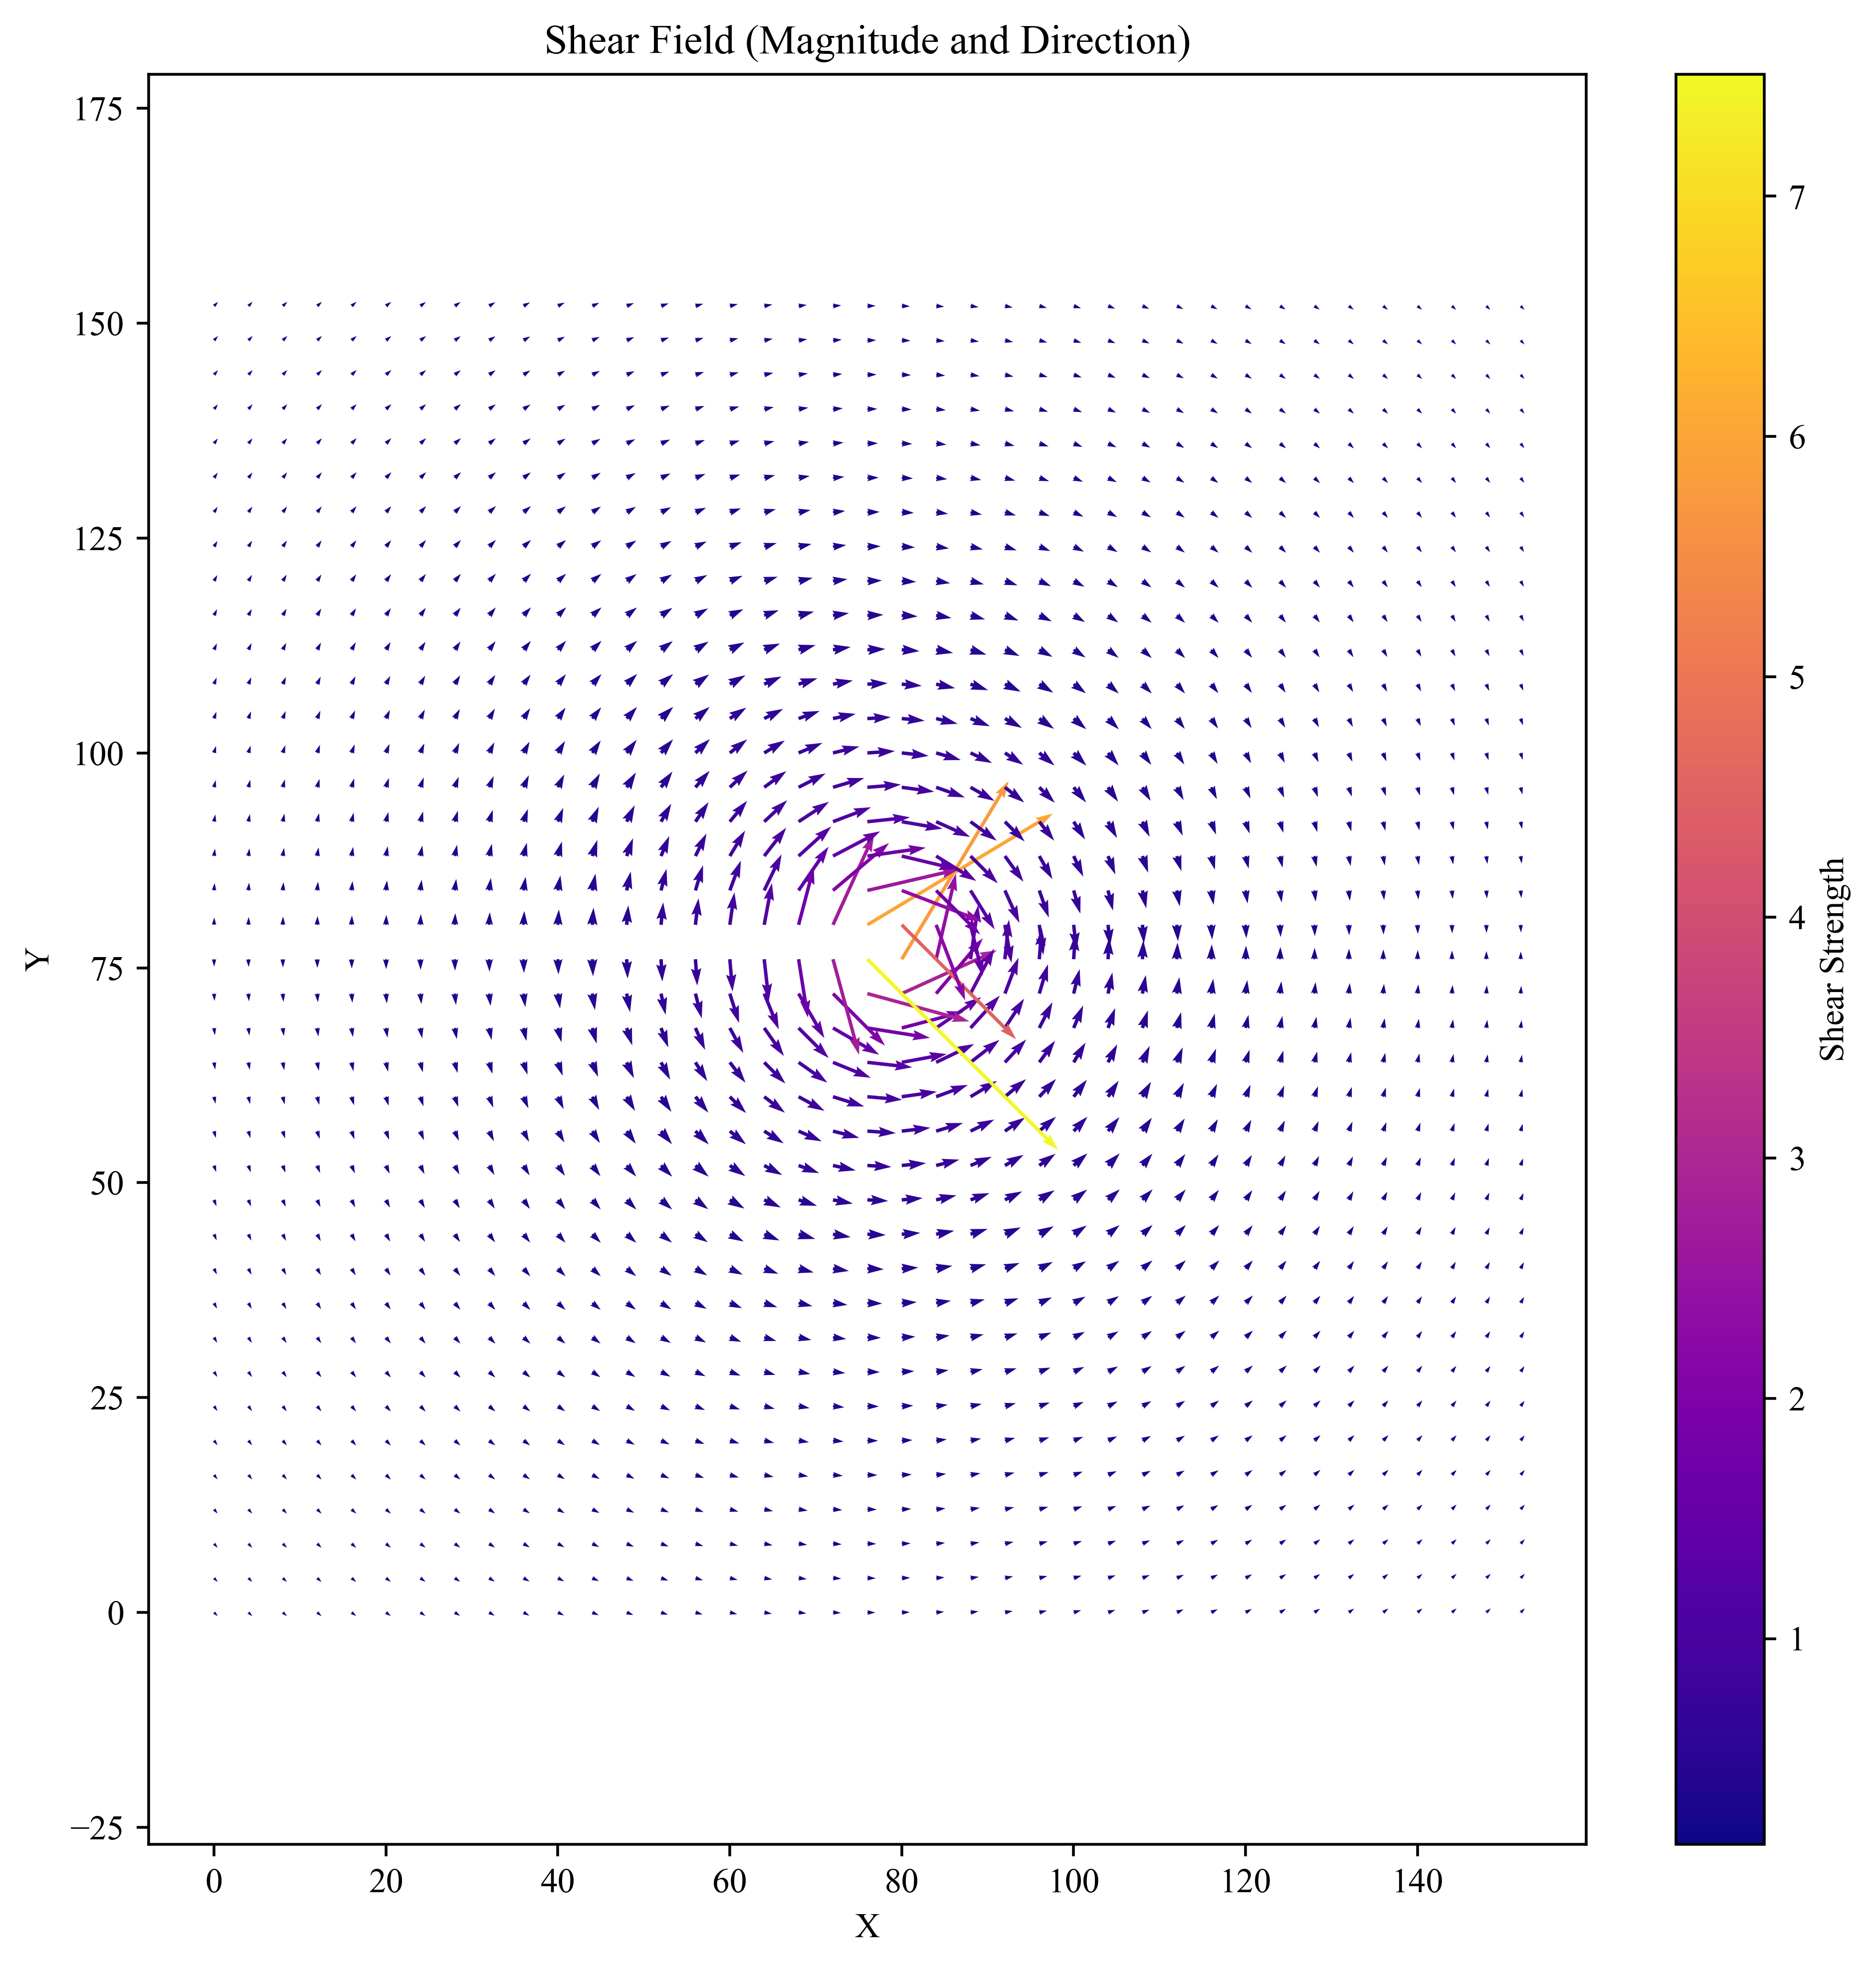

In [ ]:
# Sample shape (use your actual gamma_tot and gamma_angle)
ny, nx = gamma_tot.shape

# Create a grid
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y)

# Convert polar to Cartesian components
U = gamma_tot * np.cos(gamma_angle)  # x-component
V = gamma_tot * np.sin(gamma_angle)  # y-component

# Plot
plt.figure(figsize=(8, 8))
step = 4
plt.quiver(X[::step, ::step], Y[::step, ::step],
           U[::step, ::step], V[::step, ::step],
           gamma_tot[::step, ::step], cmap='plasma', scale=40)

plt.title('Shear Field (Magnitude and Direction)')
plt.axis('equal')
plt.colorbar(label='Shear Strength')
plt.xlabel('X')
plt.ylabel('Y')
# plt.xlim(48, 108)
# plt.ylim(48, 108)
plt.tight_layout()
plt.show()


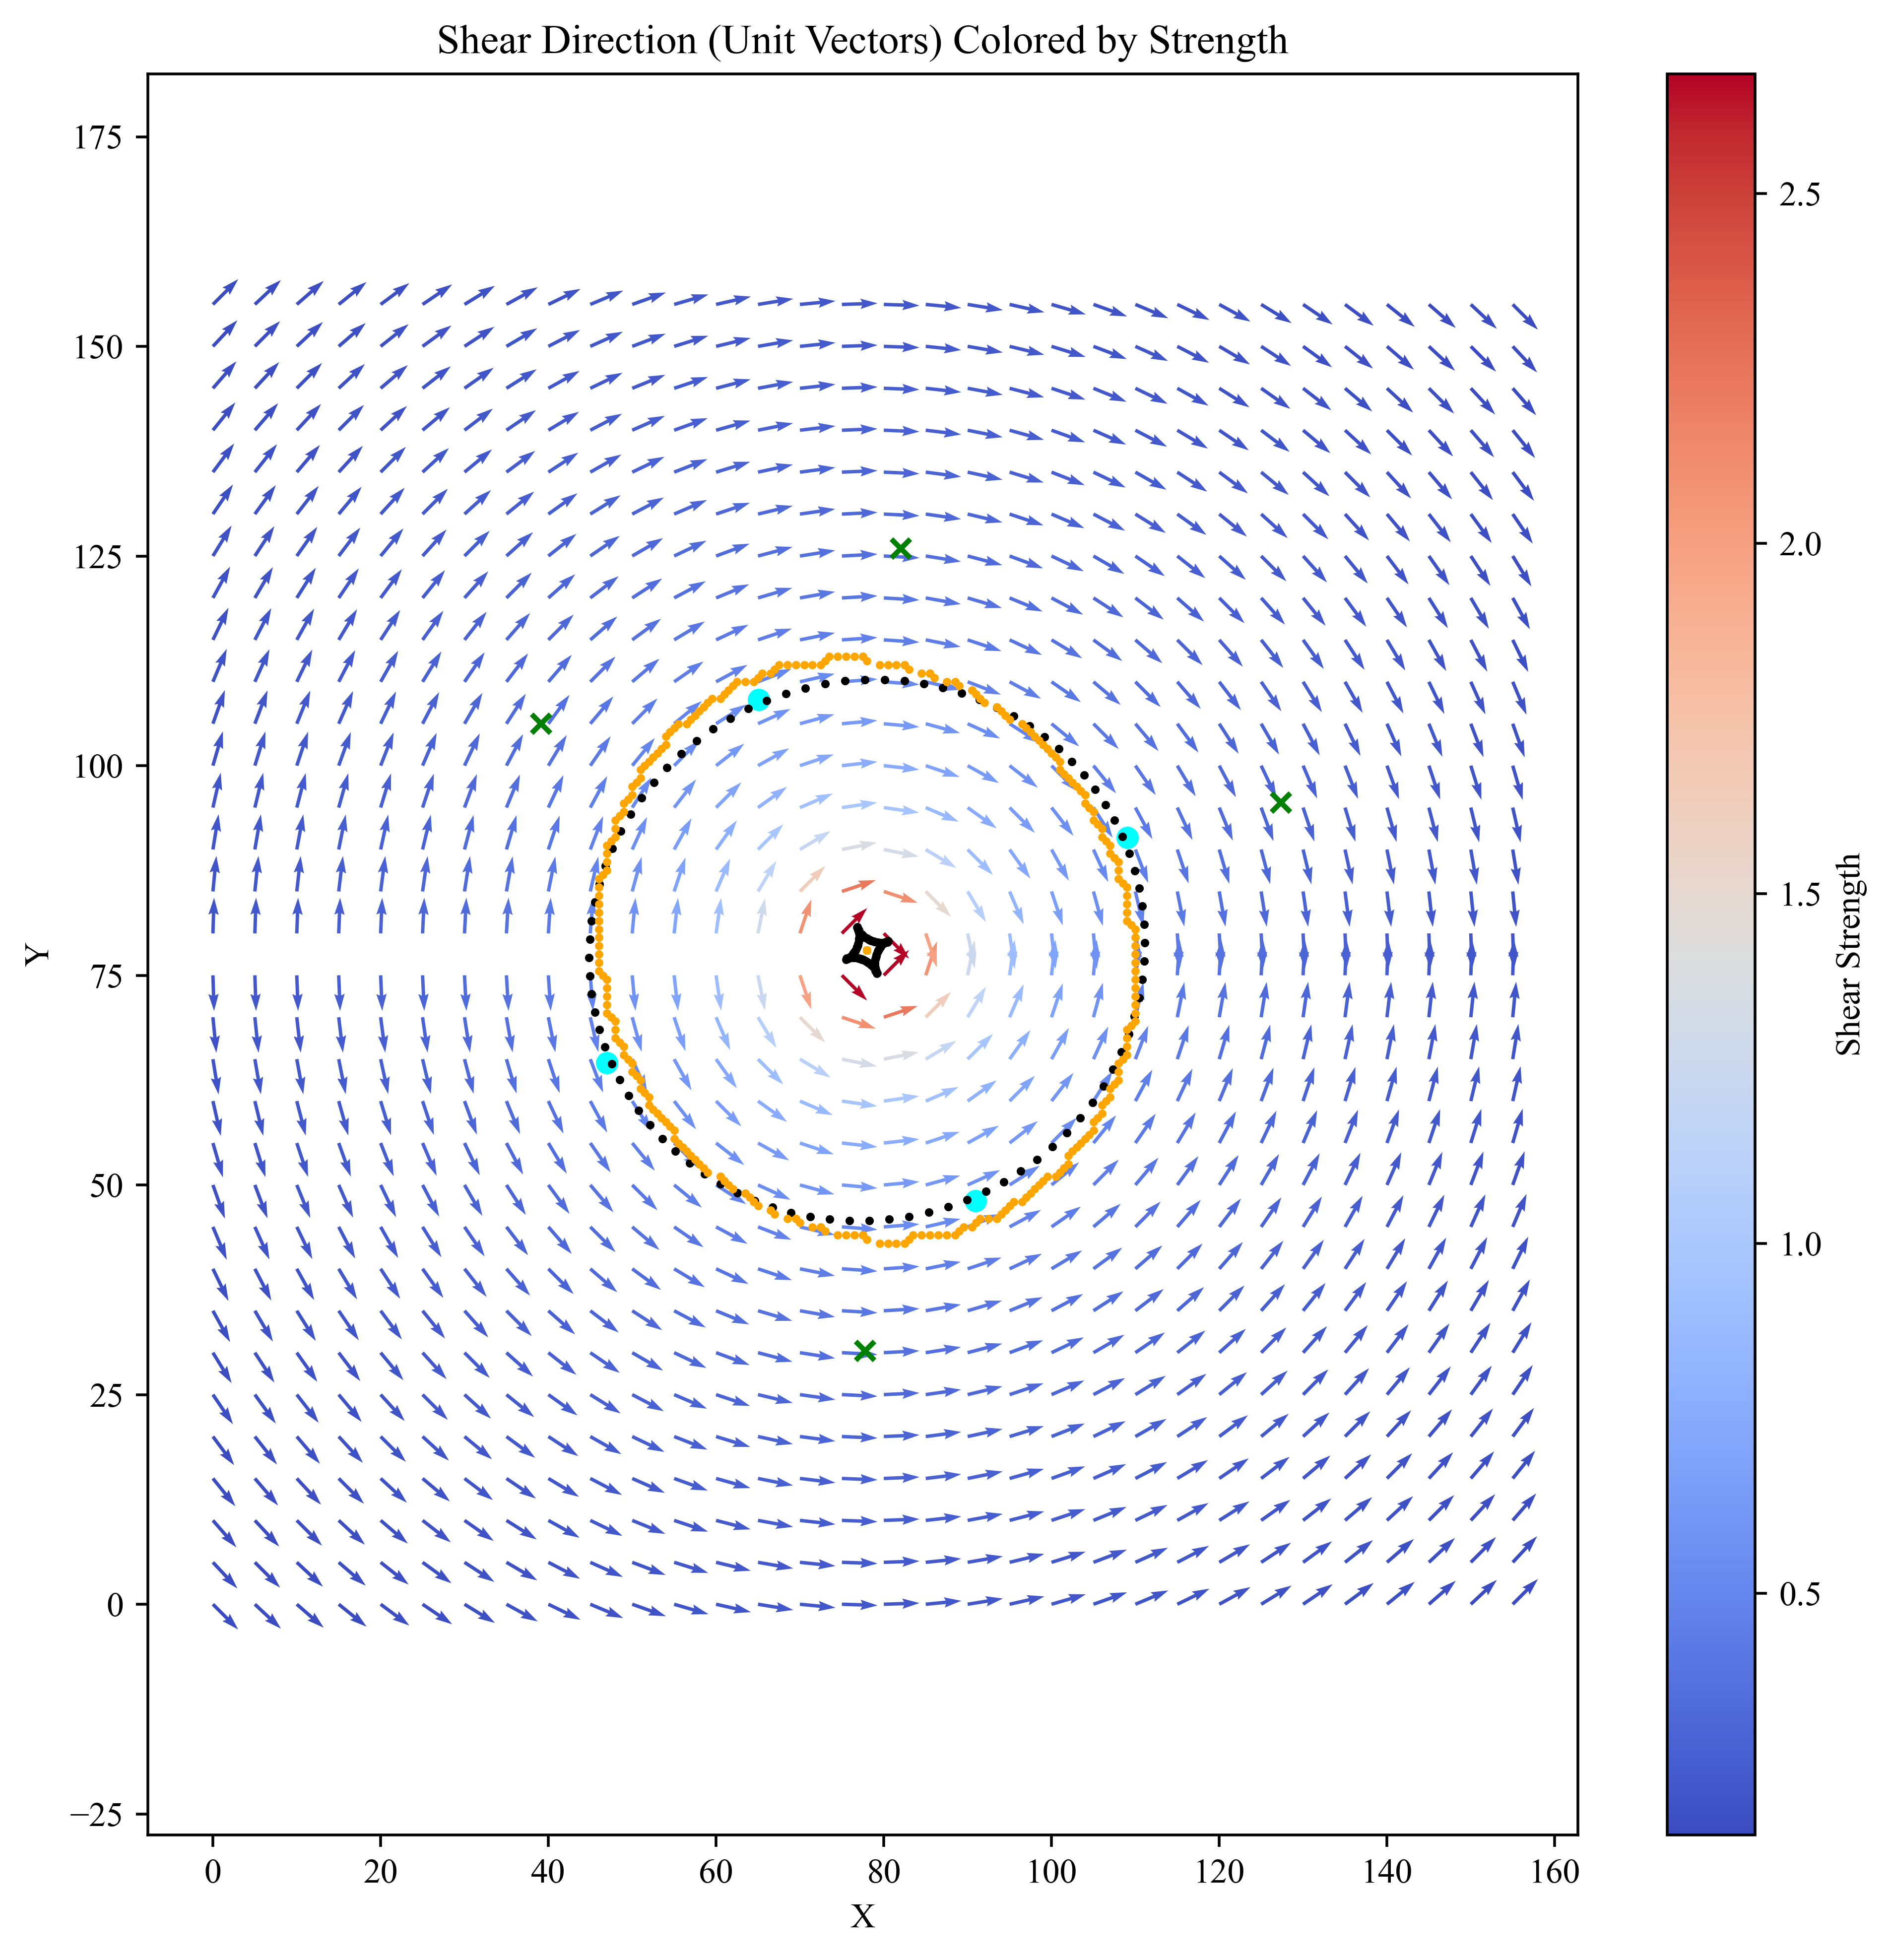

In [55]:
# Assume gamma_tot and gamma_angle are given (same shape)
ny, nx = gamma_tot.shape
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y)

# Normalize directions (unit vectors)
U = np.cos(gamma_angle)
V = np.sin(gamma_angle)

vmax, vmin = np.percentile(gamma_tot, [99.5, 0.5])


# Plot: constant arrow size, color = shear strength
plt.figure(figsize=(8, 8))
step = 5
q = plt.quiver(X[::step, ::step], Y[::step, ::step],
           U[::step, ::step], V[::step, ::step],
           gamma_tot[::step, ::step], cmap='coolwarm', scale=40, norm=ImageNormalize(vmin=vmin, vmax=vmax))

plt.scatter(obs_point[0], obs_point[1], color='green', s=30, label='Observed Points', marker='x')
plt.scatter(pred_point_sorted[0], pred_point_sorted[1], color='cyan', s=30, label='Predicted Points', marker='o')
plt.scatter(crit_curve[2], crit_curve[3], color='black', s=2, label='Caustic')
plt.scatter(crit_curve[4], crit_curve[5], color='orange', s=2, label='Critical Curve')

plt.title('Shear Direction (Unit Vectors) Colored by Strength')
plt.axis('equal')
plt.colorbar(q, label='Shear Strength')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()
